ELEC6910X Advanced Topics in AI and Healthcare

# Assignment 1 - Problem 1: 3D Segmentation

***Holy Lovenia - 20814158***

------

In [1]:
import glob
import logging
import os
from pathlib import Path
import shutil
import sys
import tempfile

import nibabel as nib
import numpy as np
from ignite.engine import create_supervised_trainer, Events
from monai.config import print_config
from monai.data import ArrayDataset, create_test_image_3d, decollate_batch, DataLoader
from monai.handlers import (
    EarlyStopHandler,
    MeanDice,
    MeanIoUHandler,
    SurfaceDistance,
    HausdorffDistance,
    StatsHandler,
    TensorBoardImageHandler,
    TensorBoardStatsHandler,
)
from monai.losses import DiceLoss
from monai.metrics import meandice
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    CenterSpatialCrop,
    ToTensor,
    NormalizeIntensity,
    AsDiscrete,
    Compose,
    LoadImage,
    RandSpatialCrop,
    Resize,
    SaveImage,
    ScaleIntensity,
)
from monai.utils import first

import h5py
import ignite
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

print_config()

MONAI version: 1.0.0
Numpy version: 1.23.1
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 170093375ce29267e45681fcec09dfa856e1d7e7
MONAI __file__: /home/holy/anaconda3/envs/health/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.2.0
Tensorboard version: 2.10.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.23.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#ins

In [2]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Problem 1: 3D Segmentation

### Data Loading

#### Function declarations

In [3]:
def problem1_load_dataset(
    dir_path,
    img_column_name="image",
    label_column_name="label"):
    
    def _load_all_data_from_dir(dir_path, img_column_name="image", label_column_name="label"):
        def _load_h5_data(file_path, img_column_name="image", label_column_name="label"):
            data = h5py.File(file_path, "r")
            image = data[img_column_name][:]
            seg = data[label_column_name][:]
            return image, seg
        
        df_dict = {"image": [], "seg": []}
        for file_name in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file_name)
            if os.path.isfile(file_path) and file_path.endswith(".h5"):
                image, seg = _load_h5_data(file_path)
                df_dict["image"].append(image)
                df_dict["seg"].append(seg)
        df = pd.DataFrame.from_dict(df_dict)
        return df
    
    df = _load_all_data_from_dir(dir_path, img_column_name, label_column_name)
    return df

#### Function utilization

Load 3D segmentation data from `problem1_datas`.

In [4]:
df = {}
df["train"] = problem1_load_dataset("./data/problem1_datas/train")
df["test"] = problem1_load_dataset("./data/problem1_datas/test")

### Preprocessing

Define transforms for the input image and the ground truth segmentation.

In [5]:
imtrans = Compose(
    [
        ScaleIntensity(),
        EnsureChannelFirst(),
        CenterSpatialCrop([96, 96, 64]),
        ToTensor(),
        NormalizeIntensity(),
    ]
)
segtrans = Compose(
    [
        EnsureChannelFirst(),
        CenterSpatialCrop([96, 96, 64]),
        ToTensor(),
        NormalizeIntensity(),
    ]
)

val_imtrans = Compose(
    [
        EnsureChannelFirst(),
        CenterSpatialCrop([96, 96, 64]),
        ToTensor(),
        NormalizeIntensity(),
    ]
)

val_segtrans = Compose(
    [
        EnsureChannelFirst(),
        CenterSpatialCrop([96, 96, 64]),
        ToTensor(),
        NormalizeIntensity(),
    ]
)

Apply the transformations to the train and the valid set. The valid set is taken from `problem1_datas/test`.

In [6]:
train_ds = ArrayDataset(df["train"]["image"], imtrans, df["train"]["seg"], segtrans)
val_ds = ArrayDataset(df["test"]["image"], val_imtrans, df["test"]["seg"], val_segtrans)

Initialize the dataloaders.

In [7]:
train_loader = DataLoader(train_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())

### Training and Evaluation

#### Function declarations

Initializer for the model and the optimizer.

In [8]:
def get_model_and_optimizer(checkpoint_path=None, lr=1e-3, device="cuda:0"):
    device = torch.device(device)
    net = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
    opt = torch.optim.Adam(net.parameters(), lr)
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        net.load_state_dict(checkpoint["net"])
        opt.load_state_dict(checkpoint["opt"])
    return net, opt

Training loop.

In [9]:
def training(net, opt, loss_fn, metrics, eval_loader, eval_epoch=1, device="cuda:0", log_name="exp1"):
    device = torch.device(device)
    
    def init_evaluator(metrics):
        post_pred = Compose(
            [Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
        )
        post_label = Compose([AsDiscrete(threshold=0.5)])

        evaluator = ignite.engine.create_supervised_evaluator(
            net,
            val_metrics,
            device,
            True,
            output_transform=lambda x, y, y_pred: (
                [post_pred(i) for i in decollate_batch(y_pred)],
                [post_label(i) for i in decollate_batch(y)]
            ),
        )
        return evaluator
    
    # Create trainer
    trainer = create_supervised_trainer(
        net, opt, loss_fn, device, False
    )
    
    log_dir = os.path.join("./save/problem1/", log_name)
    
    # Add handlers
    checkpoint_handler = ignite.handlers.ModelCheckpoint(
        log_dir, "net", n_saved=1, require_empty=False
    )
    trainer.add_event_handler(
        event_name=ignite.engine.Events.EPOCH_COMPLETED,
        handler=checkpoint_handler,
        to_save={"net": net, "opt": opt},
    )
    
    train_stats_handler = StatsHandler(name="trainer", output_transform=lambda x: x)
    train_stats_handler.attach(trainer)
    
    train_tensorboard_stats_handler = TensorBoardStatsHandler(log_dir=log_dir, output_transform=lambda x: x)
    train_tensorboard_stats_handler.attach(trainer)
    
    evaluator = init_evaluator(metrics)
    @trainer.on(
        ignite.engine.Events.EPOCH_COMPLETED(every=eval_epoch)
    )
    def run_validation(engine):
        evaluator.run(val_loader)
    
    val_stats_handler = StatsHandler(
        name="evaluator",
        output_transform=lambda x: None,
        global_epoch_transform=lambda x: trainer.state.epoch,
    )
    val_stats_handler.attach(evaluator)

    val_tensorboard_stats_handler = TensorBoardStatsHandler(
        log_dir=log_dir,
        output_transform=lambda x: x,
        global_epoch_transform=lambda x: trainer.state.epoch,
    )
    val_tensorboard_stats_handler.attach(evaluator)

    val_tensorboard_image_handler = TensorBoardImageHandler(
        log_dir=log_dir,
        batch_transform=lambda batch: (batch[0], batch[1]),
        output_transform=lambda output: output[0],
        global_iter_transform=lambda x: trainer.state.epoch,
    )
    evaluator.add_event_handler(
        event_name=ignite.engine.Events.EPOCH_COMPLETED,
        handler=val_tensorboard_image_handler,
    )
    return trainer, evaluator

Prediction and the result display.

In [10]:
def predict(net, img, seg, sample_id):
    res = net(img.cuda().unsqueeze(dim=0))
    y = (torch.sigmoid(res) >= 0.5).squeeze()
    
    f, axarr = plt.subplots(3)
    plt.suptitle(
        f"Input image #{sample_id} (top), predicted segmentation (middle), and ground truth segmentation (bottom)",
        fontsize=8)
    axarr[0].imshow(img.squeeze().numpy()[0, ...])
    axarr[1].imshow(y.cpu().numpy()[0, ...])
    axarr[2].imshow(seg.squeeze().numpy()[0, ...])

Other training and evaluation settings.

In [11]:
loss_fn = DiceLoss(sigmoid=True)

In [12]:
val_metrics = {
    "dice": MeanDice(),
    "jaccard": MeanIoUHandler(),
    "asd": SurfaceDistance(),
    "hausdorff95": HausdorffDistance(percentile=95)}

### Experiment 1: Normal/Default (`1e-3`)

In [13]:
net, opt = get_model_and_optimizer(checkpoint_path=None, lr=1e-3)

In [14]:
trainer, evaluator = training(net, opt, loss_fn, val_metrics, val_loader, log_name="exp1")

Start training.

In [15]:
max_epochs = 20
state = trainer.run(train_loader, max_epochs)

2022-10-17 19:41:32,363 - Engine run starting with max_epochs=20.
2022-10-17 19:41:39,985 - Epoch: 1/20, Iter: 1/7 -- Loss: 1.0436 
2022-10-17 19:41:40,066 - Epoch: 1/20, Iter: 2/7 -- Loss: 0.9233 
2022-10-17 19:41:40,126 - Epoch: 1/20, Iter: 3/7 -- Loss: 0.8733 
2022-10-17 19:41:40,185 - Epoch: 1/20, Iter: 4/7 -- Loss: 0.7853 
2022-10-17 19:41:40,248 - Epoch: 1/20, Iter: 5/7 -- Loss: 0.7826 
2022-10-17 19:41:40,632 - Epoch: 1/20, Iter: 6/7 -- Loss: 0.7091 
2022-10-17 19:41:40,697 - Epoch: 1/20, Iter: 7/7 -- Loss: 0.7487 
2022-10-17 19:41:40,899 - Engine run starting with max_epochs=1.


/home/holy/anaconda3/envs/health/lib/python3.10/site-packages/monai/handlers/tensorboard_handlers.py:260: UserWarning: ignoring non-scalar output in TensorBoardStatsHandler, make sure `output_transform(engine.state.output)` returns a scalar or a dictionary of key and scalar pairs to avoid this warning. <class 'tuple'>
  warnings.warn(


2022-10-17 19:41:52,701 - Epoch[1] Metrics -- asd: 10.1956 dice: 0.6240 hausdorff95: 26.8144 jaccard: 0.4610 
2022-10-17 19:41:53,066 - Epoch[1] Complete. Time taken: 00:00:11.901
2022-10-17 19:41:53,068 - Engine run complete. Time taken: 00:00:12.167
2022-10-17 19:41:53,248 - Epoch[1] Complete. Time taken: 00:00:20.690
2022-10-17 19:41:54,393 - Epoch: 2/20, Iter: 1/7 -- Loss: 0.7754 
2022-10-17 19:41:54,513 - Epoch: 2/20, Iter: 2/7 -- Loss: 0.5705 
2022-10-17 19:41:54,878 - Epoch: 2/20, Iter: 3/7 -- Loss: 0.5994 
2022-10-17 19:41:54,967 - Epoch: 2/20, Iter: 4/7 -- Loss: 0.6081 
2022-10-17 19:41:55,365 - Epoch: 2/20, Iter: 5/7 -- Loss: 0.6088 
2022-10-17 19:41:55,443 - Epoch: 2/20, Iter: 6/7 -- Loss: 0.5907 
2022-10-17 19:41:55,846 - Epoch: 2/20, Iter: 7/7 -- Loss: 0.6022 
2022-10-17 19:41:56,064 - Engine run starting with max_epochs=1.
2022-10-17 19:42:07,700 - Epoch[2] Metrics -- asd: 10.0862 dice: 0.6865 hausdorff95: 25.8147 jaccard: 0.5336 
2022-10-17 19:42:08,121 - Epoch[1] Comple

2022-10-17 19:43:47,186 - Epoch: 11/20, Iter: 5/7 -- Loss: -0.0236 
2022-10-17 19:43:47,417 - Epoch: 11/20, Iter: 6/7 -- Loss: 0.0115 
2022-10-17 19:43:47,650 - Epoch: 11/20, Iter: 7/7 -- Loss: 0.0180 
2022-10-17 19:43:47,841 - Engine run starting with max_epochs=1.
2022-10-17 19:43:55,423 - Epoch[11] Metrics -- asd: 4.1825 dice: 0.8330 hausdorff95: 15.1442 jaccard: 0.7219 
2022-10-17 19:43:55,761 - Epoch[1] Complete. Time taken: 00:00:07.709
2022-10-17 19:43:55,762 - Engine run complete. Time taken: 00:00:07.920
2022-10-17 19:43:55,893 - Epoch[11] Complete. Time taken: 00:00:10.446
2022-10-17 19:43:56,751 - Epoch: 12/20, Iter: 1/7 -- Loss: 0.1228 
2022-10-17 19:43:56,836 - Epoch: 12/20, Iter: 2/7 -- Loss: -0.1276 
2022-10-17 19:43:57,209 - Epoch: 12/20, Iter: 3/7 -- Loss: -0.0808 
2022-10-17 19:43:57,309 - Epoch: 12/20, Iter: 4/7 -- Loss: 0.0374 
2022-10-17 19:43:57,684 - Epoch: 12/20, Iter: 5/7 -- Loss: -0.0958 
2022-10-17 19:43:57,788 - Epoch: 12/20, Iter: 6/7 -- Loss: -0.1098 
2022

2022-10-17 19:45:42,750 - Engine run complete. Time taken: 00:00:10.056
2022-10-17 19:45:42,876 - Epoch[20] Complete. Time taken: 00:00:13.351
2022-10-17 19:45:42,880 - Engine run complete. Time taken: 00:04:10.515


Output the eval performance.

In [16]:
evaluator.run(val_loader)

2022-10-17 19:45:43,056 - Engine run starting with max_epochs=1.
2022-10-17 19:45:52,560 - Epoch[20] Metrics -- asd: 3.1545 dice: 0.8592 hausdorff95: 12.3979 jaccard: 0.7575 
2022-10-17 19:45:52,908 - Epoch[1] Complete. Time taken: 00:00:09.471
2022-10-17 19:45:52,912 - Engine run complete. Time taken: 00:00:09.853


State:
	iteration: 10
	epoch: 1
	epoch_length: 10
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'monai.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	metric_details: <class 'dict'>

Prediction results.

In [18]:
net, opt = get_model_and_optimizer(checkpoint_path="./save/problem1/exp1/net_checkpoint_140.pt")

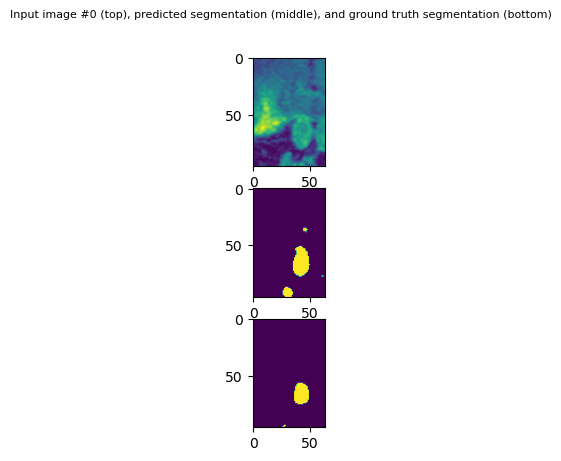

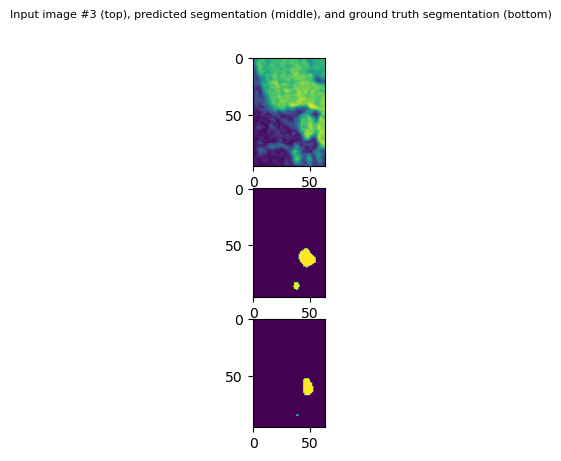

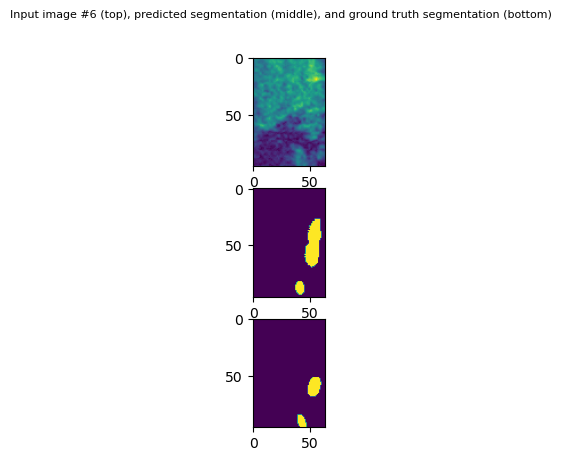

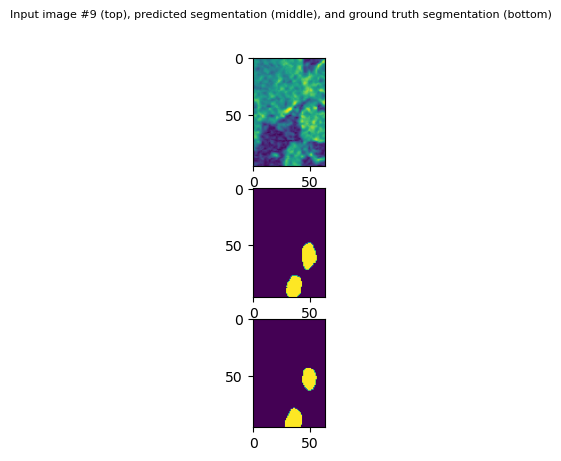

In [19]:
sample_ids = [0, 3, 6, 9]
for sample_id in sample_ids:
    predict(net, val_ds[sample_id][0], val_ds[sample_id][1], sample_id=sample_id)

### Experiment 2: Lower learning rate (`5e-4`)

In [20]:
net, opt = get_model_and_optimizer(checkpoint_path=None, lr=5e-4)

In [21]:
trainer, evaluator = training(net, opt, loss_fn, val_metrics, val_loader, log_name="exp2")

Start training.

In [22]:
max_epochs = 20
state = trainer.run(train_loader, max_epochs)

2022-10-17 19:48:38,546 - Engine run starting with max_epochs=20.
2022-10-17 19:48:39,801 - Epoch: 1/20, Iter: 1/7 -- Loss: 1.0422 
2022-10-17 19:48:39,903 - Epoch: 1/20, Iter: 2/7 -- Loss: 0.9709 
2022-10-17 19:48:40,326 - Epoch: 1/20, Iter: 3/7 -- Loss: 0.9117 
2022-10-17 19:48:40,395 - Epoch: 1/20, Iter: 4/7 -- Loss: 0.8458 
2022-10-17 19:48:40,859 - Epoch: 1/20, Iter: 5/7 -- Loss: 0.8181 
2022-10-17 19:48:40,946 - Epoch: 1/20, Iter: 6/7 -- Loss: 0.7813 
2022-10-17 19:48:41,314 - Epoch: 1/20, Iter: 7/7 -- Loss: 0.8328 
2022-10-17 19:48:41,503 - Engine run starting with max_epochs=1.
2022-10-17 19:48:53,501 - Epoch[1] Metrics -- asd: 9.9471 dice: 0.5536 hausdorff95: 25.7986 jaccard: 0.3867 
2022-10-17 19:48:53,872 - Epoch[1] Complete. Time taken: 00:00:12.088
2022-10-17 19:48:53,873 - Engine run complete. Time taken: 00:00:12.369
2022-10-17 19:48:54,089 - Epoch[1] Complete. Time taken: 00:00:15.269
2022-10-17 19:48:55,303 - Epoch: 2/20, Iter: 1/7 -- Loss: 0.7772 
2022-10-17 19:48:55,

2022-10-17 19:50:45,934 - Epoch[10] Metrics -- asd: 4.4667 dice: 0.8342 hausdorff95: 15.1694 jaccard: 0.7233 
2022-10-17 19:50:46,285 - Epoch[1] Complete. Time taken: 00:00:09.898
2022-10-17 19:50:46,287 - Engine run complete. Time taken: 00:00:10.151
2022-10-17 19:50:46,418 - Epoch[10] Complete. Time taken: 00:00:12.829
2022-10-17 19:50:47,364 - Epoch: 11/20, Iter: 1/7 -- Loss: 0.3056 
2022-10-17 19:50:47,448 - Epoch: 11/20, Iter: 2/7 -- Loss: 0.1824 
2022-10-17 19:50:47,797 - Epoch: 11/20, Iter: 3/7 -- Loss: 0.2290 
2022-10-17 19:50:47,900 - Epoch: 11/20, Iter: 4/7 -- Loss: 0.2512 
2022-10-17 19:50:48,261 - Epoch: 11/20, Iter: 5/7 -- Loss: 0.2005 
2022-10-17 19:50:48,339 - Epoch: 11/20, Iter: 6/7 -- Loss: 0.2421 
2022-10-17 19:50:48,736 - Epoch: 11/20, Iter: 7/7 -- Loss: 0.2147 
2022-10-17 19:50:48,931 - Engine run starting with max_epochs=1.
2022-10-17 19:50:56,929 - Epoch[11] Metrics -- asd: 4.7482 dice: 0.8335 hausdorff95: 17.0675 jaccard: 0.7186 
2022-10-17 19:50:57,105 - Epoch[1

2022-10-17 19:52:49,719 - Epoch: 20/20, Iter: 4/7 -- Loss: 0.0323 
2022-10-17 19:52:49,824 - Epoch: 20/20, Iter: 5/7 -- Loss: -0.0111 
2022-10-17 19:52:50,132 - Epoch: 20/20, Iter: 6/7 -- Loss: -0.0197 
2022-10-17 19:52:50,261 - Epoch: 20/20, Iter: 7/7 -- Loss: 0.0201 
2022-10-17 19:52:50,485 - Engine run starting with max_epochs=1.
2022-10-17 19:53:01,278 - Epoch[20] Metrics -- asd: 3.3440 dice: 0.8603 hausdorff95: 12.1556 jaccard: 0.7602 
2022-10-17 19:53:01,606 - Epoch[1] Complete. Time taken: 00:00:10.852
2022-10-17 19:53:01,607 - Engine run complete. Time taken: 00:00:11.120
2022-10-17 19:53:01,872 - Epoch[20] Complete. Time taken: 00:00:14.398
2022-10-17 19:53:01,874 - Engine run complete. Time taken: 00:04:23.317


Output the eval performance.

In [23]:
evaluator.run(val_loader)

2022-10-17 19:54:50,362 - Engine run starting with max_epochs=1.
2022-10-17 19:55:00,640 - Epoch[20] Metrics -- asd: 3.3440 dice: 0.8603 hausdorff95: 12.1556 jaccard: 0.7602 
2022-10-17 19:55:00,980 - Epoch[1] Complete. Time taken: 00:00:10.363
2022-10-17 19:55:00,982 - Engine run complete. Time taken: 00:00:10.617


State:
	iteration: 10
	epoch: 1
	epoch_length: 10
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'monai.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	metric_details: <class 'dict'>

Prediction results.

In [24]:
net, opt = get_model_and_optimizer(checkpoint_path="./save/problem1/exp2/net_checkpoint_140.pt")

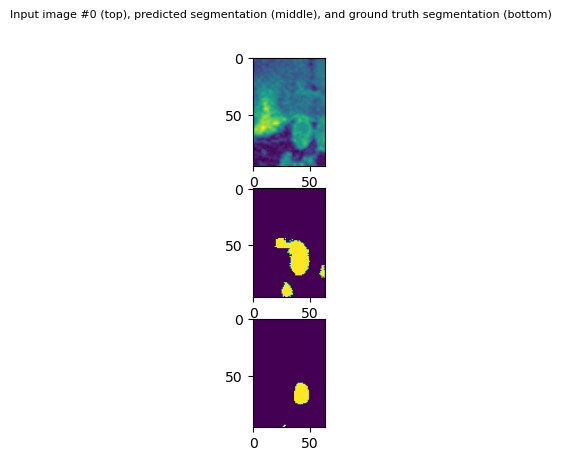

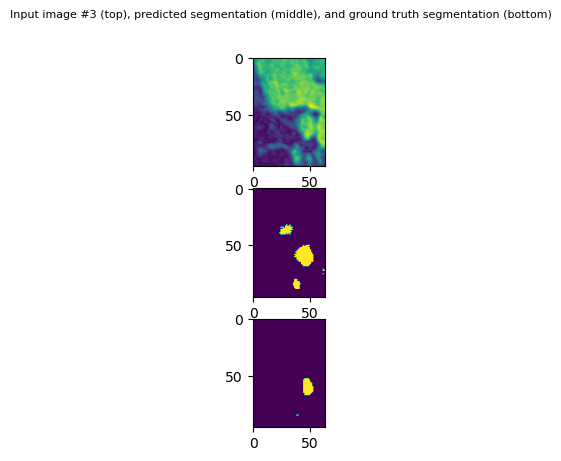

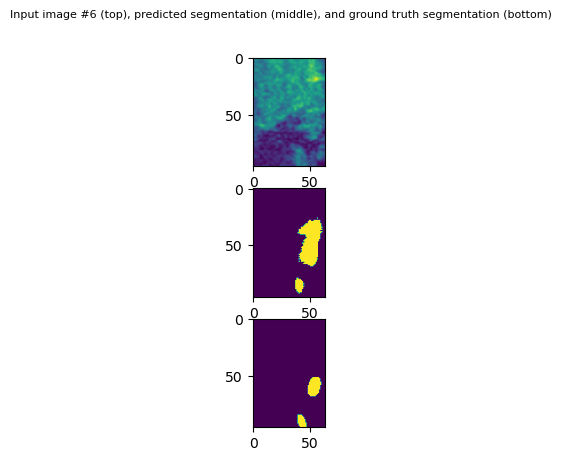

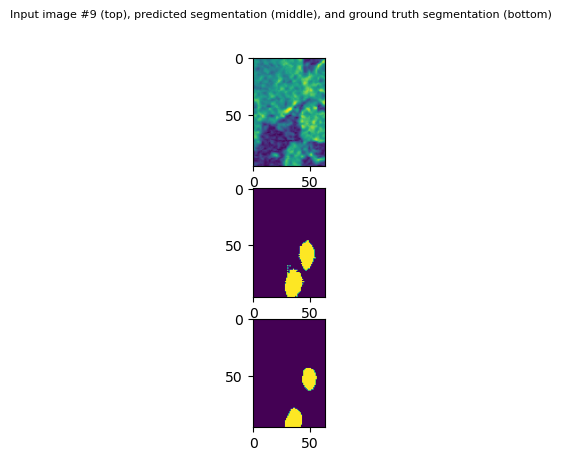

In [25]:
sample_ids = [0, 3, 6, 9]
for sample_id in sample_ids:
    predict(net, val_ds[sample_id][0], val_ds[sample_id][1], sample_id=sample_id)

### Experiment 3: Higher learning rate (`5e-3`)

In [32]:
net, opt = get_model_and_optimizer(checkpoint_path=None, lr=5e-3)

In [33]:
trainer, evaluator = training(net, opt, loss_fn, val_metrics, val_loader, log_name="exp3")

Start training.

In [34]:
max_epochs = 40
state = trainer.run(train_loader, max_epochs)

2022-10-17 20:07:49,903 - Engine run starting with max_epochs=40.
2022-10-17 20:07:50,896 - Epoch: 1/40, Iter: 1/7 -- Loss: 0.9964 
2022-10-17 20:07:50,965 - Epoch: 1/40, Iter: 2/7 -- Loss: 0.7683 
2022-10-17 20:07:51,280 - Epoch: 1/40, Iter: 3/7 -- Loss: 0.6600 
2022-10-17 20:07:51,457 - Epoch: 1/40, Iter: 4/7 -- Loss: 0.5656 
2022-10-17 20:07:51,723 - Epoch: 1/40, Iter: 5/7 -- Loss: 0.6677 
2022-10-17 20:07:51,963 - Epoch: 1/40, Iter: 6/7 -- Loss: 0.5316 
2022-10-17 20:07:52,119 - Epoch: 1/40, Iter: 7/7 -- Loss: 0.7053 
2022-10-17 20:07:52,302 - Engine run starting with max_epochs=1.
2022-10-17 20:08:02,804 - Epoch[1] Metrics -- asd: 11.0541 dice: 0.6237 hausdorff95: 28.6700 jaccard: 0.4663 
2022-10-17 20:08:03,142 - Epoch[1] Complete. Time taken: 00:00:10.578
2022-10-17 20:08:03,144 - Engine run complete. Time taken: 00:00:10.841
2022-10-17 20:08:03,272 - Epoch[1] Complete. Time taken: 00:00:13.116
2022-10-17 20:08:04,258 - Epoch: 2/40, Iter: 1/7 -- Loss: 0.5908 
2022-10-17 20:08:04

2022-10-17 20:09:50,107 - Engine run starting with max_epochs=1.
2022-10-17 20:09:59,591 - Epoch[10] Metrics -- asd: 3.5230 dice: 0.7994 hausdorff95: 13.2846 jaccard: 0.6716 
2022-10-17 20:09:59,929 - Epoch[1] Complete. Time taken: 00:00:09.566
2022-10-17 20:09:59,931 - Engine run complete. Time taken: 00:00:09.822
2022-10-17 20:10:00,104 - Epoch[10] Complete. Time taken: 00:00:12.930
2022-10-17 20:10:01,602 - Epoch: 11/40, Iter: 1/7 -- Loss: -1.5395 
2022-10-17 20:10:01,845 - Epoch: 11/40, Iter: 2/7 -- Loss: -1.7062 
2022-10-17 20:10:02,075 - Epoch: 11/40, Iter: 3/7 -- Loss: -1.4734 
2022-10-17 20:10:02,373 - Epoch: 11/40, Iter: 4/7 -- Loss: -1.4076 
2022-10-17 20:10:02,657 - Epoch: 11/40, Iter: 5/7 -- Loss: -1.8989 
2022-10-17 20:10:02,813 - Epoch: 11/40, Iter: 6/7 -- Loss: -1.2911 
2022-10-17 20:10:03,324 - Epoch: 11/40, Iter: 7/7 -- Loss: -1.7791 
2022-10-17 20:10:03,571 - Engine run starting with max_epochs=1.
2022-10-17 20:10:12,826 - Epoch[11] Metrics -- asd: 3.8129 dice: 0.7594

2022-10-17 20:11:40,150 - Epoch: 20/40, Iter: 2/7 -- Loss: -1.9405 
2022-10-17 20:11:40,487 - Epoch: 20/40, Iter: 3/7 -- Loss: -1.8350 
2022-10-17 20:11:40,599 - Epoch: 20/40, Iter: 4/7 -- Loss: -1.8423 
2022-10-17 20:11:40,984 - Epoch: 20/40, Iter: 5/7 -- Loss: -2.4098 
2022-10-17 20:11:41,042 - Epoch: 20/40, Iter: 6/7 -- Loss: -1.8178 
2022-10-17 20:11:41,466 - Epoch: 20/40, Iter: 7/7 -- Loss: -2.5675 
2022-10-17 20:11:41,645 - Engine run starting with max_epochs=1.
2022-10-17 20:11:49,279 - Epoch[20] Metrics -- asd: 4.9232 dice: 0.6674 hausdorff95: 17.1776 jaccard: 0.5064 
2022-10-17 20:11:49,467 - Epoch[1] Complete. Time taken: 00:00:07.604
2022-10-17 20:11:49,468 - Engine run complete. Time taken: 00:00:07.822
2022-10-17 20:11:49,592 - Epoch[20] Complete. Time taken: 00:00:10.524
2022-10-17 20:11:50,372 - Epoch: 21/40, Iter: 1/7 -- Loss: -2.7796 
2022-10-17 20:11:50,680 - Epoch: 21/40, Iter: 2/7 -- Loss: -1.9282 
2022-10-17 20:11:50,821 - Epoch: 21/40, Iter: 3/7 -- Loss: -1.7935 


2022-10-17 20:13:31,909 - Epoch[29] Metrics -- asd: 5.0119 dice: 0.6734 hausdorff95: 17.1102 jaccard: 0.5135 
2022-10-17 20:13:32,228 - Epoch[1] Complete. Time taken: 00:00:09.585
2022-10-17 20:13:32,229 - Engine run complete. Time taken: 00:00:09.880
2022-10-17 20:13:32,368 - Epoch[29] Complete. Time taken: 00:00:13.021
2022-10-17 20:13:33,432 - Epoch: 30/40, Iter: 1/7 -- Loss: -3.2375 
2022-10-17 20:13:33,787 - Epoch: 30/40, Iter: 2/7 -- Loss: -1.9915 
2022-10-17 20:13:33,901 - Epoch: 30/40, Iter: 3/7 -- Loss: -1.8769 
2022-10-17 20:13:34,291 - Epoch: 30/40, Iter: 4/7 -- Loss: -2.0881 
2022-10-17 20:13:34,383 - Epoch: 30/40, Iter: 5/7 -- Loss: -2.5075 
2022-10-17 20:13:34,769 - Epoch: 30/40, Iter: 6/7 -- Loss: -1.8476 
2022-10-17 20:13:34,830 - Epoch: 30/40, Iter: 7/7 -- Loss: -2.7093 
2022-10-17 20:13:35,026 - Engine run starting with max_epochs=1.
2022-10-17 20:13:43,727 - Epoch[30] Metrics -- asd: 5.7598 dice: 0.5916 hausdorff95: 19.6798 jaccard: 0.4251 
2022-10-17 20:13:44,054 - 

2022-10-17 20:15:05,255 - Epoch: 39/40, Iter: 3/7 -- Loss: -1.8872 
2022-10-17 20:15:05,316 - Epoch: 39/40, Iter: 4/7 -- Loss: -2.1195 
2022-10-17 20:15:05,677 - Epoch: 39/40, Iter: 5/7 -- Loss: -2.5270 
2022-10-17 20:15:05,765 - Epoch: 39/40, Iter: 6/7 -- Loss: -1.8831 
2022-10-17 20:15:06,148 - Epoch: 39/40, Iter: 7/7 -- Loss: -2.8235 
2022-10-17 20:15:06,338 - Engine run starting with max_epochs=1.
2022-10-17 20:15:14,276 - Epoch[39] Metrics -- asd: 5.1010 dice: 0.6410 hausdorff95: 18.3535 jaccard: 0.4781 
2022-10-17 20:15:14,551 - Epoch[1] Complete. Time taken: 00:00:08.048
2022-10-17 20:15:14,552 - Engine run complete. Time taken: 00:00:08.213
2022-10-17 20:15:14,683 - Epoch[39] Complete. Time taken: 00:00:10.856
2022-10-17 20:15:15,643 - Epoch: 40/40, Iter: 1/7 -- Loss: -3.4245 
2022-10-17 20:15:15,741 - Epoch: 40/40, Iter: 2/7 -- Loss: -1.9976 
2022-10-17 20:15:15,995 - Epoch: 40/40, Iter: 3/7 -- Loss: -1.8872 
2022-10-17 20:15:16,195 - Epoch: 40/40, Iter: 4/7 -- Loss: -2.1198 


Output the eval performance.

In [35]:
evaluator.run(val_loader)

2022-10-17 20:15:26,073 - Engine run starting with max_epochs=1.
2022-10-17 20:15:32,779 - Epoch[40] Metrics -- asd: 5.1902 dice: 0.6439 hausdorff95: 17.8868 jaccard: 0.4806 
2022-10-17 20:15:32,968 - Epoch[1] Complete. Time taken: 00:00:06.651
2022-10-17 20:15:32,969 - Engine run complete. Time taken: 00:00:06.894


State:
	iteration: 10
	epoch: 1
	epoch_length: 10
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'monai.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	metric_details: <class 'dict'>

Prediction results.

In [36]:
net, opt = get_model_and_optimizer(checkpoint_path="./save/problem1/exp3/net_checkpoint_280.pt")

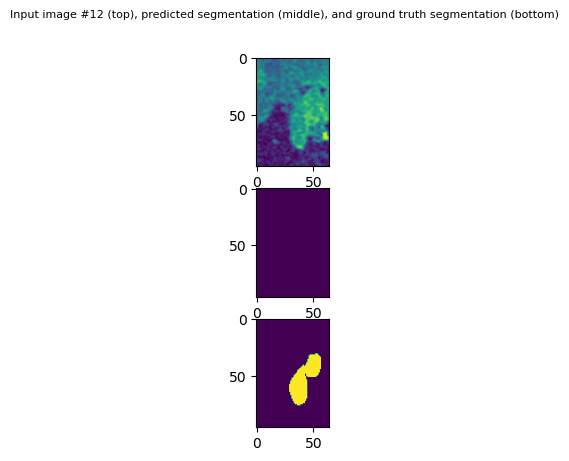

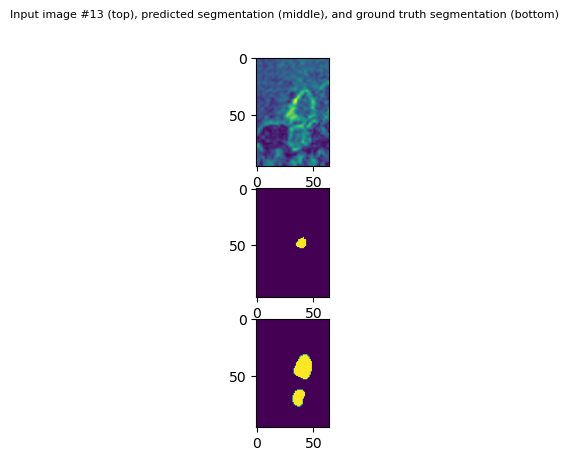

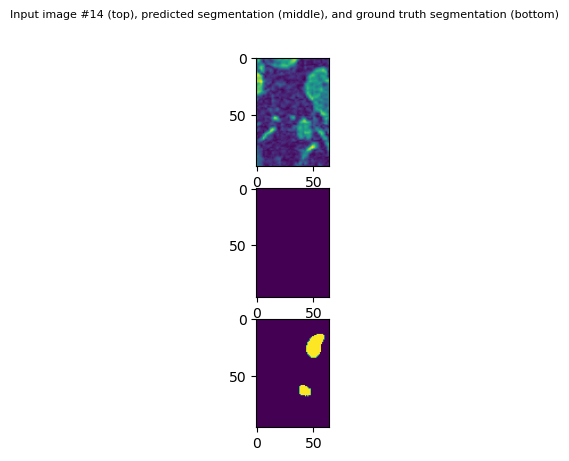

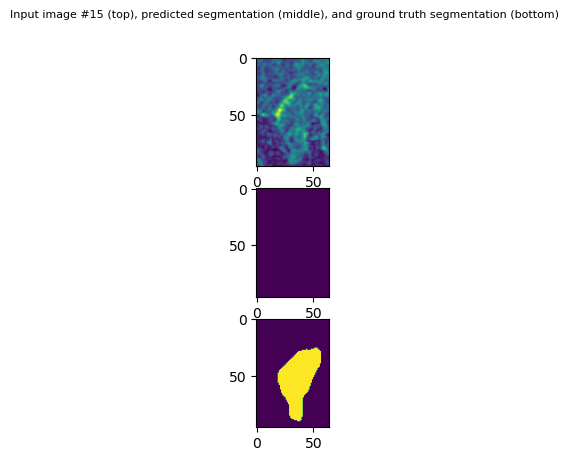

In [52]:
sample_ids = [12, 13, 14, 15]
for sample_id in sample_ids:
    predict(net, val_ds[sample_id][0], val_ds[sample_id][1], sample_id=sample_id)

### Conclusion

Train loss for Experiment 1 (light blue), Experiment 2 (pink), and Experiment 3 (yellow).

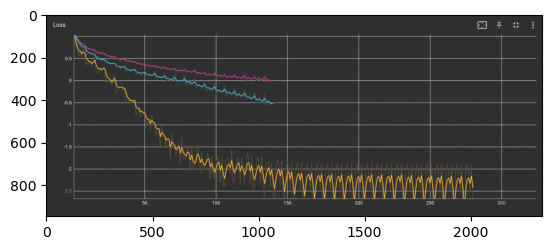

In [54]:
plt.figure()
img = mpimg.imread("./log/problem1/exp_train_loss.png")
plt.imshow(img)

|Exp. ID|Exp. Setting|Eval. ASD|Eval. Dice|Eval. Hausdorff (95%)| Eval. Jaccard|
|-------|------------|---------|----------|---------------------|--------------|
|1|3D UNet (lr=1e-3)|3.15|<u>85.92%</u>|12.40|75.75%|
|2|3D UNet (lr=5e-4)|3.34|**86.03%**|12.16|76.02%|
|3|3D UNet (lr=5e-3)|5.19|64.39%|17.89|48.06%|

In this notebook, I have:

1) tried out 3 different experiment configurations;

2) reported the results (i.e., train loss, eval loss, eval dice, eval ASD, eval hausdorff, and eval jaccard);

3) showed the train loss curve and predicted segmentation results (in the form of 2D slices); and

4) achieved a best performance of 86.03% using 3D UNet (through Experiment 2) for 3D segmentation on medical data.